In [1]:
import pandas as pd
import numpy as np

PATH = "btcusdt_1h_merged.csv"

df = pd.read_csv(PATH, parse_dates=["ts"])
df = df.sort_values("ts").reset_index(drop=True)

df["target_log_ret_1h"] = df["log_ret_1h"].shift(-1)

df = df.dropna(subset=["target_log_ret_1h"]).reset_index(drop=True)

df.head()

,ts,open,high,low,close,volume,quote_volume,num_trades,taker_buy_base,taker_buy_quote,...,premium_close,fundingRate,markPrice,buyVol,sellVol,buySellRatio,taker_imbalance,sumOpenInterest,sumOpenInterestValue,target_log_ret_1h
0,2023-01-01 00:00:00+00:00,16537.5,16540.9,16504.0,16527.0,5381.399,8.892309e+07,31529,2541.791,4.200065e+07,...,-0.000222,0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001415
1,2023-01-01 01:00:00+00:00,16527.1,16554.3,16524.1,16550.4,3210.826,5.309855e+07,19787,1933.859,3.198225e+07,...,-0.000059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000483
2,2023-01-01 02:00:00+00:00,16550.5,16557.1,16534.8,16542.4,2399.668,3.970466e+07,15720,1156.721,1.913896e+07,...,-0.000386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000792
3,2023-01-01 03:00:00+00:00,16542.5,16542.5,16515.0,16529.3,3214.480,5.312060e+07,19341,1430.403,2.363773e+07,...,-0.000271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000696
4,2023-01-01 04:00:00+00:00,16529.2,16530.4,16508.8,16517.8,3150.954,5.204823e+07,20937,1583.098,2.615013e+07,...,-0.000246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000478


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    """
    Scale-free regression metrics for 1h log-returns.

    Returns dict with:
      - nrmse:         normalized RMSE = RMSE / std(y_true)
      - mae_over_std:  MAE / std(y_true)
      - r2:            coefficient of determination
      - corr:          Pearson correlation
      - directional_accuracy: share of correct sign predictions
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Basic metrics, but scale-free
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    std_y = np.std(y_true)
    if std_y == 0:
        nrmse = np.nan
        mae_over_std = np.nan
    else:
        nrmse = rmse / std_y
        mae_over_std = mae / std_y

    # R^2
    r2 = r2_score(y_true, y_pred)

    # Pearson correlation
    if np.std(y_pred) == 0 or np.std(y_true) == 0:
        corr = np.nan
    else:
        corr = np.corrcoef(y_true, y_pred)[0, 1]

    # Directional accuracy
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    mask = (sign_true != 0) & (sign_pred != 0)
    if mask.sum() == 0:
        dir_acc = np.nan
    else:
        dir_acc = (sign_true[mask] == sign_pred[mask]).mean()

    return {
        "nrmse": nrmse,
        "mae_over_std": mae_over_std,
        "r2": r2,
        "corr": corr,
        "directional_accuracy": dir_acc,
    }


Split dataset

In [3]:
base_features = [
    "close", "volume", "quote_volume", "num_trades",
    "taker_buy_base", "taker_buy_quote",
    "premium_close",
    "fundingRate", "markPrice",
    "log_ret_1h",  # прошлый ретёрн как фича
]

extra_features = [
    "buyVol", "sellVol", "buySellRatio", "taker_imbalance",
    "sumOpenInterest", "sumOpenInterestValue",
]

feat_A = [c for c in base_features  if c in df.columns]
feat_B = feat_A + [c for c in extra_features if c in df.columns]


In [4]:
for col in ["fundingRate", "markPrice", "premium_close"]:
    if col in df.columns:
        df[col] = df[col].ffill()

In [ ]:
df = df.sort_values("ts").reset_index(drop=True)

df_B = df.dropna(subset=feat_B + ["target_log_ret_1h"]).copy()
df_B = df_B.sort_values("ts").reset_index(drop=True)

print("df_B shape:", df_B.shape, "| ts range:", df_B["ts"].min(), "→", df_B["ts"].max())

if len(df_B) == 0:
    raise ValueError("df_B is empty – no rows with all extra_features present")

boundary_ts = df_B["ts"].min()
print("Boundary ts for separation A/B:", boundary_ts)

df_A_full = df.dropna(subset=feat_A + ["target_log_ret_1h"]).copy()
df_A_full = df_A_full.sort_values("ts").reset_index(drop=True)

df_A = df_A_full[df_A_full["ts"] < boundary_ts].copy()
df_A = df_A.sort_values("ts").reset_index(drop=True)

print("df_A shape:", df_A.shape, "| ts range:", df_A["ts"].min(), "→", df_A["ts"].max())


df_B shape: (499, 21) | ts range: 2025-10-12 23:00:00+00:00 → 2025-11-02 17:00:00+00:00
Boundary ts for separation A/B: 2025-10-12 23:00:00+00:00
df_A shape: (17103, 21) | ts range: 2023-10-31 08:00:00+00:00 → 2025-10-12 22:00:00+00:00


In [ ]:
def make_time_splits(
    df_in,
    feature_cols,
    train_frac=0.6,
    val_frac=0.2,
    test_frac=0.2,
):
    """
    Time-ordered split: first train_frac for train, next val_frac for val, rest for test.
    Assumes df_in already sorted by 'ts'.
    """
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-8, \
        "Fractions must sum to 1"

    df_in = df_in.sort_values("ts").reset_index(drop=True)
    n = len(df_in)

    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)
    df_train = df_in.iloc[:n_train]
    df_val   = df_in.iloc[n_train:n_train + n_val]
    df_test  = df_in.iloc[n_train + n_val:]

    X_train = df_train[feature_cols].values
    y_train = df_train["target_log_ret_1h"].values

    X_val   = df_val[feature_cols].values
    y_val   = df_val["target_log_ret_1h"].values

    X_test  = df_test[feature_cols].values
    y_test  = df_test["target_log_ret_1h"].values

    return (
        df_train, df_val, df_test,
        X_train, y_train,
        X_val,   y_val,
        X_test,  y_test,
    )


In [7]:
(df_train_A, df_val_A, df_test_A,
 X_train_A, y_train_A,
 X_val_A,   y_val_A,
 X_test_A,  y_test_A) = make_time_splits(df_A, feat_A, 
                                         train_frac=0.7, val_frac=0.15, test_frac=0.15)

len(df_train_A), len(df_val_A), len(df_test_A)


(11972, 2565, 2566)

In [8]:
(df_train_B, df_val_B, df_test_B,
 X_train_B, y_train_B,
 X_val_B,   y_val_B,
 X_test_B,  y_test_B) = make_time_splits(df_B, feat_B, 
                                         train_frac=0.6, val_frac=0.2, test_frac=0.2)

len(df_train_B), len(df_val_B), len(df_test_B)


(299, 99, 101)

Trying baseline

In [ ]:
metrics_rows = []

def add_metric_row(model_name, split_name, metrics_dict, n_samples):
    row = {
        "model": model_name,
        "split": split_name,
        "n_samples": n_samples,
    }
    row.update(metrics_dict)
    metrics_rows.append(row)


In [ ]:
y_pred_val_baseline_A  = df_val_A["log_ret_1h"].values
y_pred_test_baseline_A = df_test_A["log_ret_1h"].values

metrics_val_baseline_A  = regression_metrics(y_val_A,  y_pred_val_baseline_A)
metrics_test_baseline_A = regression_metrics(y_test_A, y_pred_test_baseline_A)

add_metric_row("A_baseline", "val",  metrics_val_baseline_A,  len(df_val_A))
add_metric_row("A_baseline", "test", metrics_test_baseline_A, len(df_test_A))

y_pred_val_baseline_B  = df_val_B["log_ret_1h"].values
y_pred_test_baseline_B = df_test_B["log_ret_1h"].values

metrics_val_baseline_B  = regression_metrics(y_val_B,  y_pred_val_baseline_B)
metrics_test_baseline_B = regression_metrics(y_test_B, y_pred_test_baseline_B)

add_metric_row("B_baseline", "val",  metrics_val_baseline_B,  len(df_val_B))
add_metric_row("B_baseline", "test", metrics_test_baseline_B, len(df_test_B))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-0.041618,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-0.009838,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,0.081940,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-0.086979,0.534653


Learning

In [11]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [12]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)


In [13]:
ridge_pipeline_A = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

param_grid_ridge = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
}

gcv_ridge_A = GridSearchCV(
    ridge_pipeline_A,
    param_grid=param_grid_ridge,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
)

gcv_ridge_A.fit(X_train_A, y_train_A)

print("Best params Ridge A:", gcv_ridge_A.best_params_)
print("Best CV score (neg MSE):", gcv_ridge_A.best_score_)


Best params Ridge A: {'model__alpha': 100.0}
Best CV score (neg MSE): -3.324156826784281e-05


In [14]:
best_ridge_A = gcv_ridge_A.best_estimator_

y_val_pred_A  = best_ridge_A.predict(X_val_A)
y_test_pred_A = best_ridge_A.predict(X_test_A)

metrics_val_ridge_A  = regression_metrics(y_val_A,  y_val_pred_A)
metrics_test_ridge_A = regression_metrics(y_test_A, y_test_pred_A)

add_metric_row("A_ridge", "val",  metrics_val_ridge_A,  len(df_val_A))
add_metric_row("A_ridge", "test", metrics_test_ridge_A, len(df_test_A))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-0.041618,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-0.009838,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,0.081940,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-0.086979,0.534653
4,A_ridge,val,2565,1.001085,0.671988,-0.002171,0.024166,0.510530
5,A_ridge,test,2566,1.006831,0.681337,-0.013708,-0.009988,0.497272


In [15]:
enet_pipeline_B = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid_enet = {
    "model__alpha": [0.0005, 0.001, 0.01, 0.1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

gcv_enet_B = GridSearchCV(
    enet_pipeline_B,
    param_grid=param_grid_enet,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
)

gcv_enet_B.fit(X_train_B, y_train_B)

print("Best params ENet B:", gcv_enet_B.best_params_)
print("Best CV score (neg MSE):", gcv_enet_B.best_score_)


Best params ENet B: {'model__alpha': 0.01, 'model__l1_ratio': 0.3}
Best CV score (neg MSE): -2.3111684482389604e-05


In [16]:
best_enet_B = gcv_enet_B.best_estimator_

y_val_pred_B  = best_enet_B.predict(X_val_B)
y_test_pred_B = best_enet_B.predict(X_test_B)

metrics_val_enet_B  = regression_metrics(y_val_B,  y_val_pred_B)
metrics_test_enet_B = regression_metrics(y_test_B, y_test_pred_B)

add_metric_row("B_enet", "val",  metrics_val_enet_B,  len(df_val_B))
add_metric_row("B_enet", "test", metrics_test_enet_B, len(df_test_B))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-4.161759e-02,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-9.838251e-03,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,8.194034e-02,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-8.697882e-02,0.534653
4,A_ridge,val,2565,1.001085,0.671988,-0.002171,2.416562e-02,0.510530
5,A_ridge,test,2566,1.006831,0.681337,-0.013708,-9.987816e-03,0.497272
6,B_enet,val,99,1.002314,0.739081,-0.004634,5.478148e-18,0.464646
7,B_enet,test,101,1.000362,0.717412,-0.000723,3.109123e-17,0.495050


In [ ]:
X_val_B_for_A  = df_val_B[feat_A].values
X_test_B_for_A = df_test_B[feat_A].values

y_val_common  = df_val_B["target_log_ret_1h"].values
y_test_common = df_test_B["target_log_ret_1h"].values

y_val_pred_A_on_B  = best_ridge_A.predict(X_val_B_for_A)
y_test_pred_A_on_B = best_ridge_A.predict(X_test_B_for_A)

y_val_pred_B  = best_enet_B.predict(X_val_B)
y_test_pred_B = best_enet_B.predict(X_test_B)

w_A = 0.5
w_B = 0.5

y_val_pred_ens_eq  = w_A * y_val_pred_A_on_B  + w_B * y_val_pred_B
y_test_pred_ens_eq = w_A * y_test_pred_A_on_B + w_B * y_test_pred_B

metrics_val_ens_eq  = regression_metrics(y_val_common,  y_val_pred_ens_eq)
metrics_test_ens_eq = regression_metrics(y_test_common, y_test_pred_ens_eq)

add_metric_row("AB_ensemble_equal", "val",  metrics_val_ens_eq,  len(df_val_B))
add_metric_row("AB_ensemble_equal", "test", metrics_test_ens_eq, len(df_test_B))

best_w = None
best_score = np.inf

for w in np.linspace(0, 1, 21):
    y_val_mix = w * y_val_pred_A_on_B + (1 - w) * y_val_pred_B
    m = regression_metrics(y_val_common, y_val_mix)
    if not np.isnan(m["nrmse"]) and m["nrmse"] < best_score:
        best_score = m["nrmse"]
        best_w = w

print("Best ensemble weight w_A:", best_w, " (w_B =", 1 - best_w, "), val nrmse:", best_score)

w_A_opt = best_w
w_B_opt = 1.0 - best_w

y_val_pred_ens_opt  = w_A_opt * y_val_pred_A_on_B  + w_B_opt * y_val_pred_B
y_test_pred_ens_opt = w_A_opt * y_test_pred_A_on_B + w_B_opt * y_test_pred_B

metrics_val_ens_opt  = regression_metrics(y_val_common,  y_val_pred_ens_opt)
metrics_test_ens_opt = regression_metrics(y_test_common, y_test_pred_ens_opt)

add_metric_row("AB_ensemble_weighted", "val",  metrics_val_ens_opt,  len(df_val_B))
add_metric_row("AB_ensemble_weighted", "test", metrics_test_ens_opt, len(df_test_B))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


Best ensemble weight w_A: 0.0  (w_B = 1.0 ), val nrmse: 1.002314314847368


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-4.161759e-02,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-9.838251e-03,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,8.194034e-02,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-8.697882e-02,0.534653
4,A_ridge,val,2565,1.001085,0.671988,-0.002171,2.416562e-02,0.510530
5,A_ridge,test,2566,1.006831,0.681337,-0.013708,-9.987816e-03,0.497272
6,B_enet,val,99,1.002314,0.739081,-0.004634,5.478148e-18,0.464646
7,B_enet,test,101,1.000362,0.717412,-0.000723,3.109123e-17,0.495050
8,AB_ensemble_equal,val,99,1.007652,0.743542,-0.015363,-1.397108e-01,0.454545
9,AB_ensemble_equal,test,101,0.996222,0.718018,0.007542,1.330264e-01,0.534653


Some features engineering

In [ ]:
# Feature engineering to reduce correlation

if {"markPrice", "close"}.issubset(df_A.columns):
    df_A["mark_minus_close"] = df_A["markPrice"] - df_A["close"]
if {"markPrice", "close"}.issubset(df_B.columns):
    df_B["mark_minus_close"] = df_B["markPrice"] - df_B["close"]

if {"taker_buy_base", "volume"}.issubset(df_A.columns):
    denom = df_A["volume"].copy()
    denom[denom == 0] = np.nan
    df_A["taker_buy_share"] = (df_A["taker_buy_base"] / denom).fillna(0.0)

if {"taker_buy_base", "volume"}.issubset(df_B.columns):
    denom = df_B["volume"].copy()
    denom[denom == 0] = np.nan
    df_B["taker_buy_share"] = (df_B["taker_buy_base"] / denom).fillna(0.0)


if {"buyVol", "sellVol"}.issubset(df_B.columns):
    denom_bs = (df_B["buyVol"] + df_B["sellVol"]).copy()
    denom_bs[denom_bs == 0] = np.nan
    df_B["buy_share"] = (df_B["buyVol"] / denom_bs).fillna(0.0)
    df_B["net_taker_flow"] = df_B["buyVol"] - df_B["sellVol"]

if {"sumOpenInterest", "sumOpenInterestValue"}.issubset(df_B.columns):
    denom_oi = df_B["sumOpenInterest"].copy()
    denom_oi[denom_oi == 0] = np.nan
    df_B["avg_open_price"] = (df_B["sumOpenInterestValue"] / denom_oi).fillna(0.0)

if {"sumOpenInterest", "volume"}.issubset(df_B.columns):
    denom_vol = df_B["volume"].copy()
    denom_vol[denom_vol == 0] = np.nan
    df_B["oi_to_volume"] = (df_B["sumOpenInterest"] / denom_vol).fillna(0.0)

print("df_A columns (tail):", [c for c in df_A.columns if c not in df_A_full.columns])
print("df_B columns (tail):", [c for c in df_B.columns if c not in df_A_full.columns])


df_A columns (tail): ['mark_minus_close', 'taker_buy_share']
df_B columns (tail): ['mark_minus_close', 'taker_buy_share', 'buy_share', 'net_taker_flow', 'avg_open_price', 'oi_to_volume']


In [ ]:
# Aggregated feature sets for A and B (less correlated)

feat_A_aggr = [
    "close",
    "log_ret_1h",
    "volume",
    "num_trades",
    "taker_buy_share",
    "premium_close",
    "fundingRate",
    "mark_minus_close",
]

feat_A_aggr = [c for c in feat_A_aggr if c in df_A.columns]
print("feat_A_aggr:", feat_A_aggr)

extra_B_aggr = [
    "taker_imbalance",
    "buy_share",
    "net_taker_flow",
    "avg_open_price",
    "oi_to_volume",
]

feat_B_aggr = feat_A_aggr + [c for c in extra_B_aggr if c in df_B.columns]
print("feat_B_aggr:", feat_B_aggr)


feat_A_aggr: ['close', 'log_ret_1h', 'volume', 'num_trades', 'taker_buy_share', 'premium_close', 'fundingRate', 'mark_minus_close']
feat_B_aggr: ['close', 'log_ret_1h', 'volume', 'num_trades', 'taker_buy_share', 'premium_close', 'fundingRate', 'mark_minus_close', 'taker_imbalance', 'buy_share', 'net_taker_flow', 'avg_open_price', 'oi_to_volume']


In [ ]:
(df_train_A_aggr, df_val_A_aggr, df_test_A_aggr,
 X_train_A_aggr, y_train_A_aggr,
 X_val_A_aggr,   y_val_A_aggr,
 X_test_A_aggr,  y_test_A_aggr) = make_time_splits(
    df_A, feat_A_aggr,
    train_frac=0.7, val_frac=0.15, test_frac=0.15
)

(df_train_B_aggr, df_val_B_aggr, df_test_B_aggr,
 X_train_B_aggr, y_train_B_aggr,
 X_val_B_aggr,   y_val_B_aggr,
 X_test_B_aggr,  y_test_B_aggr) = make_time_splits(
    df_B, feat_B_aggr,
    train_frac=0.6, val_frac=0.2, test_frac=0.2
)

len(df_train_A_aggr), len(df_val_A_aggr), len(df_test_A_aggr), len(df_train_B_aggr), len(df_val_B_aggr), len(df_test_B_aggr)


(11972, 2565, 2566, 299, 99, 101)

In [ ]:
# Ridge A with aggregated features

ridge_pipeline_A_aggr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

gcv_ridge_A_aggr = GridSearchCV(
    ridge_pipeline_A_aggr,
    param_grid=param_grid_ridge,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
)

gcv_ridge_A_aggr.fit(X_train_A_aggr, y_train_A_aggr)

print("Best params Ridge A (aggr):", gcv_ridge_A_aggr.best_params_)
print("Best CV score (neg MSE, aggr):", gcv_ridge_A_aggr.best_score_)

best_ridge_A_aggr = gcv_ridge_A_aggr.best_estimator_

y_val_pred_A_aggr  = best_ridge_A_aggr.predict(X_val_A_aggr)
y_test_pred_A_aggr = best_ridge_A_aggr.predict(X_test_A_aggr)

metrics_val_ridge_A_aggr  = regression_metrics(y_val_A_aggr,  y_val_pred_A_aggr)
metrics_test_ridge_A_aggr = regression_metrics(y_test_A_aggr, y_test_pred_A_aggr)

add_metric_row("A_ridge_aggr", "val",  metrics_val_ridge_A_aggr,  len(df_val_A_aggr))
add_metric_row("A_ridge_aggr", "test", metrics_test_ridge_A_aggr, len(df_test_A_aggr))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


Best params Ridge A (aggr): {'model__alpha': 100.0}
Best CV score (neg MSE, aggr): -3.3222032478017456e-05


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-4.161759e-02,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-9.838251e-03,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,8.194034e-02,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-8.697882e-02,0.534653
4,A_ridge,val,2565,1.001085,0.671988,-0.002171,2.416562e-02,0.510530
5,A_ridge,test,2566,1.006831,0.681337,-0.013708,-9.987816e-03,0.497272
6,B_enet,val,99,1.002314,0.739081,-0.004634,5.478148e-18,0.464646
7,B_enet,test,101,1.000362,0.717412,-0.000723,3.109123e-17,0.495050
8,AB_ensemble_equal,val,99,1.007652,0.743542,-0.015363,-1.397108e-01,0.454545
9,AB_ensemble_equal,test,101,0.996222,0.718018,0.007542,1.330264e-01,0.534653


In [ ]:

enet_pipeline_B_aggr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

gcv_enet_B_aggr = GridSearchCV(
    enet_pipeline_B_aggr,
    param_grid=param_grid_enet,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
)

gcv_enet_B_aggr.fit(X_train_B_aggr, y_train_B_aggr)

print("Best params ENet B (aggr):", gcv_enet_B_aggr.best_params_)
print("Best CV score (neg MSE, aggr):", gcv_enet_B_aggr.best_score_)

best_enet_B_aggr = gcv_enet_B_aggr.best_estimator_

y_val_pred_B_aggr  = best_enet_B_aggr.predict(X_val_B_aggr)
y_test_pred_B_aggr = best_enet_B_aggr.predict(X_test_B_aggr)

metrics_val_enet_B_aggr  = regression_metrics(y_val_B_aggr,  y_val_pred_B_aggr)
metrics_test_enet_B_aggr = regression_metrics(y_test_B_aggr, y_test_pred_B_aggr)

add_metric_row("B_enet_aggr", "val",  metrics_val_enet_B_aggr,  len(df_val_B_aggr))
add_metric_row("B_enet_aggr", "test", metrics_test_enet_B_aggr, len(df_test_B_aggr))

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


Best params ENet B (aggr): {'model__alpha': 0.001, 'model__l1_ratio': 0.9}
Best CV score (neg MSE, aggr): -2.3111684482389604e-05


,model,split,n_samples,nrmse,mae_over_std,r2,corr,directional_accuracy
0,A_baseline,val,2565,1.443429,0.994972,-1.083486,-4.161759e-02,0.492002
1,A_baseline,test,2566,1.421088,0.975375,-1.019490,-9.838251e-03,0.500000
2,B_baseline,val,99,1.352841,1.006644,-0.830178,8.194034e-02,0.565657
3,B_baseline,test,101,1.475087,1.041129,-1.175883,-8.697882e-02,0.534653
4,A_ridge,val,2565,1.001085,0.671988,-0.002171,2.416562e-02,0.510530
5,A_ridge,test,2566,1.006831,0.681337,-0.013708,-9.987816e-03,0.497272
6,B_enet,val,99,1.002314,0.739081,-0.004634,5.478148e-18,0.464646
7,B_enet,test,101,1.000362,0.717412,-0.000723,3.109123e-17,0.495050
8,AB_ensemble_equal,val,99,1.007652,0.743542,-0.015363,-1.397108e-01,0.454545
9,AB_ensemble_equal,test,101,0.996222,0.718018,0.007542,1.330264e-01,0.534653


Some visualizations

,ts,target_log_ret_1h,close,log_ret_1h,volume,num_trades,premium_close,fundingRate,taker_buy_share,mark_minus_close,y_pred_A_aggr,y_pred_baseline_A
0,2025-09-30 11:00:00+00:00,-0.000475,113003.7,0.001126,3668.640,77866,-0.000585,0.000023,0.605460,-884.1,-0.000412,0.001126
1,2025-09-30 12:00:00+00:00,0.003435,112950.0,-0.000475,4126.324,82593,-0.000494,0.000023,0.533220,-830.4,-0.000384,-0.000475
2,2025-09-30 13:00:00+00:00,0.001770,113338.7,0.003435,9314.459,198776,-0.000513,0.000023,0.537690,-1219.1,-0.000215,0.003435
3,2025-09-30 14:00:00+00:00,-0.004273,113539.5,0.001770,7033.239,216804,-0.000510,0.000023,0.456324,-1419.9,-0.000047,0.001770
4,2025-09-30 15:00:00+00:00,-0.002274,113055.4,-0.004273,4992.914,152876,-0.000461,0.000023,0.451060,-935.8,-0.000120,-0.004273


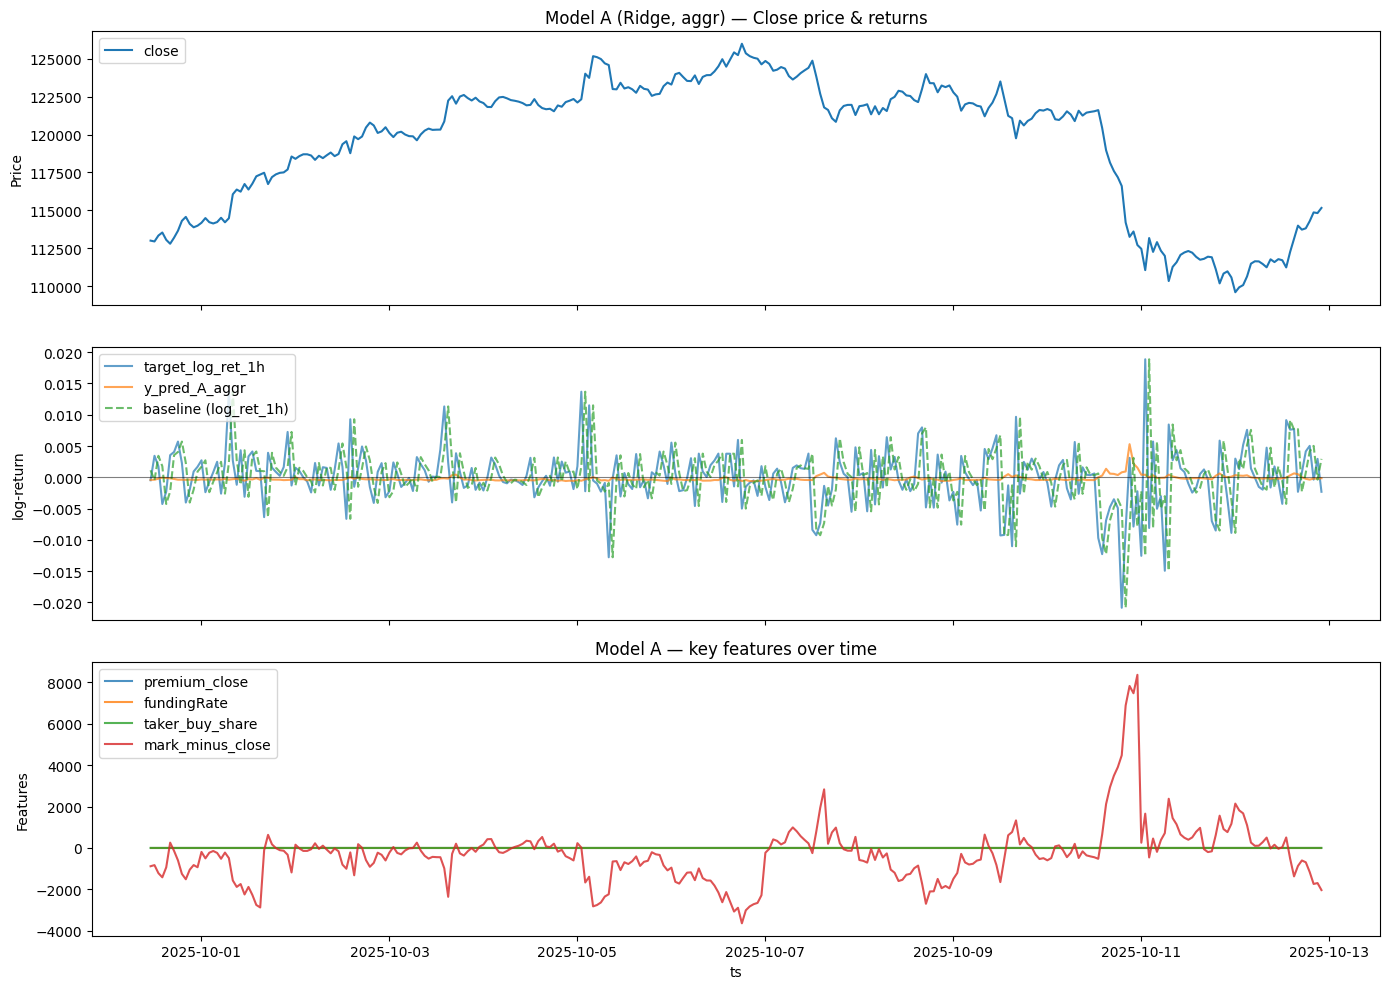

In [26]:
# %% [markdown]
# Visualization for Model A (Ridge, aggregated features) on TEST + baseline

import matplotlib.pyplot as plt

# baseline на тесте A: ŷ = log_ret_1h
y_test_baseline_A_aggr = df_test_A_aggr["log_ret_1h"].values

# Собираем DataFrame для тестового отрезка A
cols_A_vis = ["ts", "target_log_ret_1h"] + [
    c for c in [
        "close",
        "log_ret_1h",
        "volume",
        "num_trades",
        "premium_close",
        "fundingRate",
        "taker_buy_share",
        "mark_minus_close",
    ]
    if c in df_test_A_aggr.columns
]

df_vis_A = df_test_A_aggr[cols_A_vis].copy()
df_vis_A["y_pred_A_aggr"]      = y_test_pred_A_aggr
df_vis_A["y_pred_baseline_A"]  = y_test_baseline_A_aggr

# Возьмём хвост (например, последние 300 часов), чтобы график был читаем
df_vis_A_tail = df_vis_A.tail(300).reset_index(drop=True)

display(df_vis_A_tail.head())

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ts_A = df_vis_A_tail["ts"]

# 1) Цена
if "close" in df_vis_A_tail.columns:
    axes[0].plot(ts_A, df_vis_A_tail["close"], label="close")
    axes[0].set_ylabel("Price")
    axes[0].set_title("Model A (Ridge, aggr) — Close price & returns")
    axes[0].legend(loc="upper left")

# 2) Таргет vs модель vs baseline
axes[1].plot(ts_A, df_vis_A_tail["target_log_ret_1h"],
             label="target_log_ret_1h", alpha=0.7)
axes[1].plot(ts_A, df_vis_A_tail["y_pred_A_aggr"],
             label="y_pred_A_aggr", alpha=0.7)
axes[1].plot(ts_A, df_vis_A_tail["y_pred_baseline_A"],
             label="baseline (log_ret_1h)", alpha=0.7, linestyle="--")

axes[1].axhline(0.0, color="black", lw=0.8, alpha=0.5)
axes[1].set_ylabel("log-return")
axes[1].legend(loc="upper left")

# 3) Ключевые фичи
feat_to_plot_A = [c for c in
                  ["premium_close", "fundingRate", "taker_buy_share", "mark_minus_close"]
                  if c in df_vis_A_tail.columns]

for c in feat_to_plot_A:
    axes[2].plot(ts_A, df_vis_A_tail[c], label=c, alpha=0.8)

axes[2].set_ylabel("Features")
axes[2].set_xlabel("ts")
axes[2].legend(loc="upper left")
axes[2].set_title("Model A — key features over time")

plt.tight_layout()
plt.show()


,ts,target_log_ret_1h,close,log_ret_1h,volume,num_trades,premium_close,fundingRate,taker_buy_share,mark_minus_close,taker_imbalance,buy_share,net_taker_flow,avg_open_price,oi_to_volume,sumOpenInterest,y_pred_B_aggr,y_pred_baseline_B
0,2025-10-29 13:00:00+00:00,-0.003425,112824.7,-0.002459,7055.854,236035,-0.000367,0.000078,0.488346,1308.176297,0.487789,0.487789,-173.602,113105.878507,10.935697,77160.679,-0.0001,-0.002459
1,2025-10-29 14:00:00+00:00,-0.008739,112438.9,-0.003425,8322.162,260356,-0.000240,0.000078,0.438804,1693.976297,0.438594,0.438594,-1030.671,112825.280181,9.303393,77424.340,-0.0001,-0.003425
2,2025-10-29 15:00:00+00:00,-0.003601,111460.6,-0.008739,16761.981,406953,-0.000445,0.000078,0.384232,2672.276297,0.384160,0.384160,-3899.107,112439.000000,4.609421,77263.026,-0.0001,-0.008739
3,2025-10-29 16:00:00+00:00,0.006814,111060.0,-0.003601,13390.953,347939,-0.000467,0.000050,0.447643,400.600000,0.446110,0.446110,-1457.835,111460.700000,5.774648,77328.043,-0.0001,-0.003601
4,2025-10-29 17:00:00+00:00,-0.009672,111819.3,0.006814,6561.139,208678,-0.000399,0.000050,0.567785,-358.700000,0.563897,0.563897,848.164,111060.100000,11.638931,76364.647,-0.0001,0.006814


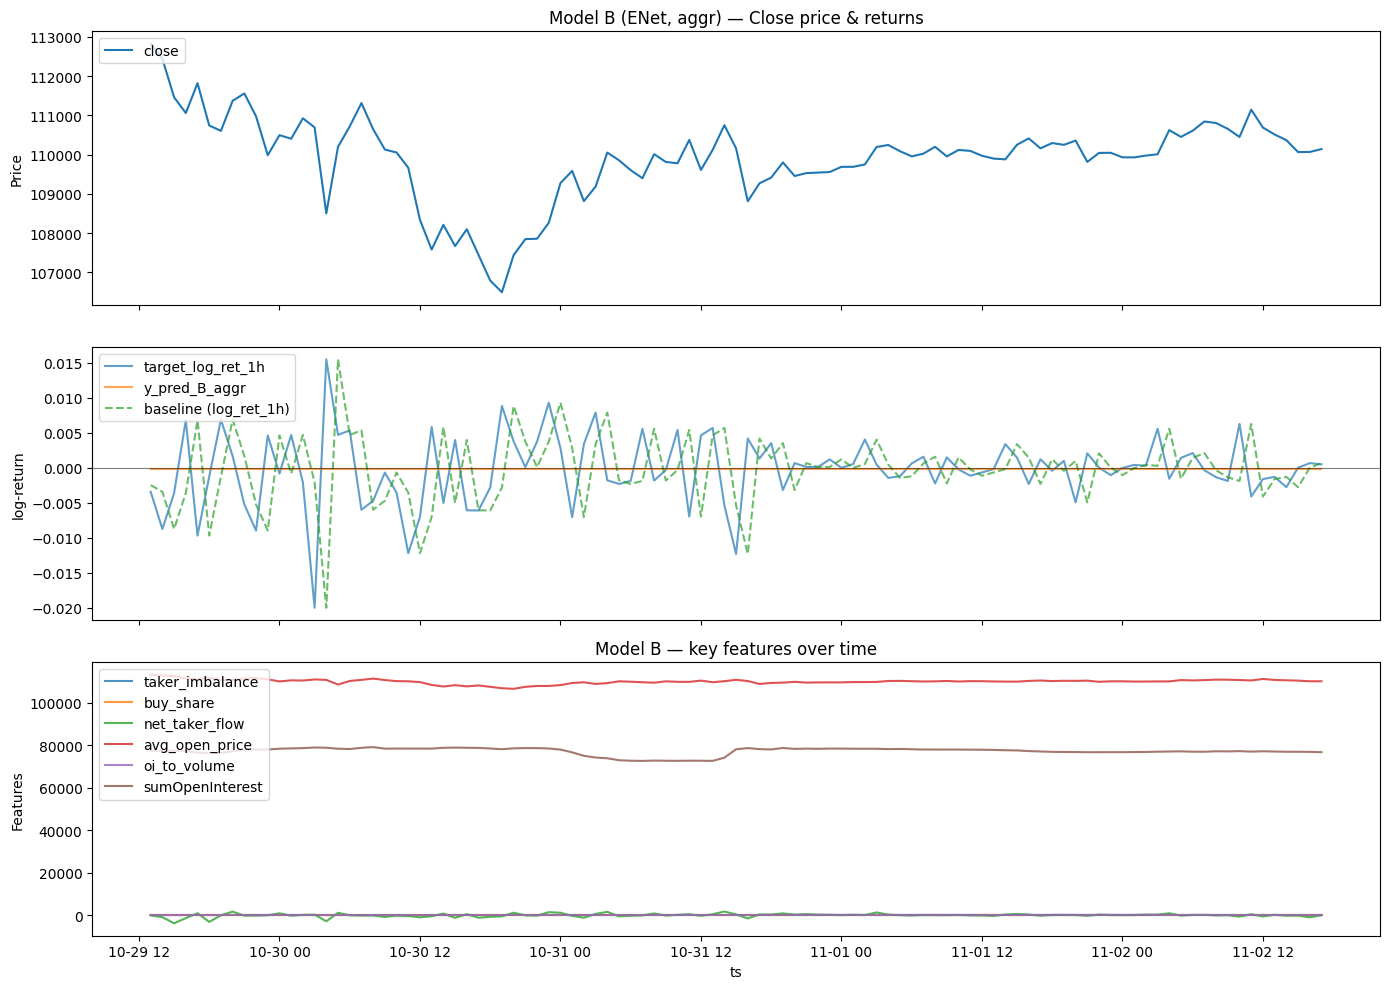

In [27]:
# %% [markdown]
# Visualization for Model B (ElasticNet, aggregated features) on TEST + baseline

# baseline на тесте B: ŷ = log_ret_1h
y_test_baseline_B_aggr = df_test_B_aggr["log_ret_1h"].values

# Собираем DataFrame для тестового отрезка B
cols_B_vis = ["ts", "target_log_ret_1h"] + [
    c for c in [
        "close",
        "log_ret_1h",
        "volume",
        "num_trades",
        "premium_close",
        "fundingRate",
        "taker_buy_share",
        "mark_minus_close",
        "taker_imbalance",
        "buy_share",
        "net_taker_flow",
        "avg_open_price",
        "oi_to_volume",
        "sumOpenInterest",
    ]
    if c in df_test_B_aggr.columns
]

df_vis_B = df_test_B_aggr[cols_B_vis].copy()
df_vis_B["y_pred_B_aggr"]      = y_test_pred_B_aggr
df_vis_B["y_pred_baseline_B"]  = y_test_baseline_B_aggr

# Хвост, чтобы не захламлять график
df_vis_B_tail = df_vis_B.tail(300).reset_index(drop=True)

display(df_vis_B_tail.head())

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ts_B = df_vis_B_tail["ts"]

# 1) Цена
if "close" in df_vis_B_tail.columns:
    axes[0].plot(ts_B, df_vis_B_tail["close"], label="close")
    axes[0].set_ylabel("Price")
    axes[0].set_title("Model B (ENet, aggr) — Close price & returns")
    axes[0].legend(loc="upper left")

# 2) Таргет vs модель vs baseline
axes[1].plot(ts_B, df_vis_B_tail["target_log_ret_1h"],
             label="target_log_ret_1h", alpha=0.7)
axes[1].plot(ts_B, df_vis_B_tail["y_pred_B_aggr"],
             label="y_pred_B_aggr", alpha=0.7)
axes[1].plot(ts_B, df_vis_B_tail["y_pred_baseline_B"],
             label="baseline (log_ret_1h)", alpha=0.7, linestyle="--")

axes[1].axhline(0.0, color="black", lw=0.8, alpha=0.5)
axes[1].set_ylabel("log-return")
axes[1].legend(loc="upper left")

# 3) Специфичные для B фичи
feat_to_plot_B = [c for c in [
    "taker_imbalance",
    "buy_share",
    "net_taker_flow",
    "avg_open_price",
    "oi_to_volume",
    "sumOpenInterest",
] if c in df_vis_B_tail.columns]

for c in feat_to_plot_B:
    axes[2].plot(ts_B, df_vis_B_tail[c], label=c, alpha=0.8)

axes[2].set_ylabel("Features")
axes[2].set_xlabel("ts")
axes[2].legend(loc="upper left")
axes[2].set_title("Model B — key features over time")

plt.tight_layout()
plt.show()


Results.

Well, as expected for linear model it predicts a constant almost all the time. I tried some basic ML tricks like assambley and feature engineering, yet no significant results. Funny thing is that I still beat baseline in terms of basic ML metrics for regression. Next time will try some tricks from time series + use some better models.